This module is for downloading VIIRS (and VIIRS-like, opitional) dataset from Google Earth Engine. The entire workflow works with a Pythonic approach.

In [1]:
# Connect to google drive and specify the file location at your 'Colab Notebooks' folder

from google.colab import drive
drive.mount('/content/drive')

program_location = '/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis'

Mounted at /content/drive


# **Set-up**

In [2]:
RW_engine = 'pyogrio'
rasterSwitch = 'NO'

Mounting your GoogleDrive

Importing module(s)

In [3]:
!pip install geopandas richdem geemap rasterio import_ipynb pyshp pycrs pyogrio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 77.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.7 MB/s eta 0:00:00
  Created wheel for richdem: filename=richdem-0.3.4-cp310-cp310-linux_x86_64.whl size=7844528 sha256=43d8ae99bc86355c1c4fd31f0a1d9a8d94e393c055b70799a153769b5da6ed7c
  Stored in directory: /root/.cache/pip/wheels/01/61/27/5c305116b5cffecf04ed75c40f640e2baf231dae20954e31e0
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=bb3c0cea0e0c5080852a5f6d027a6df6abc2121481ab116ae44e432194713702
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built richdem pycrs


In [4]:
# Colab default packages
import io
import os
import types
import sys
import glob
import importlib
import numpy as np
import pandas as pd
import json
import ee
from shapely.geometry import mapping
from shapely import geometry

# Temporarily installed packages
import geopandas as gpd
import rasterio
import richdem as rd
import geemap
import pyogrio
import pycrs
import import_ipynb

# Import external files
os.chdir(program_location)
!pwd

sys.path.append(program_location)

import tools
importlib.reload(tools)

/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis


<module 'tools' from '/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/tools.py'>

In [5]:
!pip install earthengine-api --upgrade
#NOTE: https://developers.google.com/earth-engine/guides/python_install

Generating an 'output' foldirectory in the target city directory

In [6]:
data_loc = os.path.join(os.getcwd(), 'data')
output_loc = os.path.join(data_loc, 'output')

print(data_loc)
print(output_loc)

if not os.path.exists(output_loc):
    os.mkdir(output_loc)

/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data
/content/drive/MyDrive/Colab Notebooks/afg_viirs_analysis/data/output




---


# **Setting AOI**

In [7]:
# Initialize GEE
try:
        ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except Exception as e:
        ee.Authenticate()
        ee.Initialize(project='###')# 'project = ###'. ### should be your own GEE project

In [10]:
# Get an AOI to extract VIIRS composites
src_adm = os.path.join(data_loc, 'adm0', 'afghan_adm0.shp')
gdf_in = tools.vec_import(RW_engine, src_adm)

gdf_in.head(6)

Vector import complete.
GDF size:1
EPSG:3857


,OBJECTID,ISO_A2,WB_ADM0_CO,WB_ADM0_NA,Shape_Leng,ISO3,UN_m49,Region,incomeG,lendingC,FID_100,latY,longX,Shape_Le_1,Shape_Area,geometry
0,1,AF,1,Afghanistan,7.132529e+06,AFG,4,South Asia,Low income,IDA,0,33.831804,66.027197,6.729824e+06,9.342930e+11,"POLYGON ((7903635.422 4647361.697, 7907151.894..."


In [11]:
# Specify the file name prefix (example: ISO_viirs_)
#viirs_prefix = 'afg_viirsLike_'
viirs_prefix = 'afg_viirs_'

<Axes: >

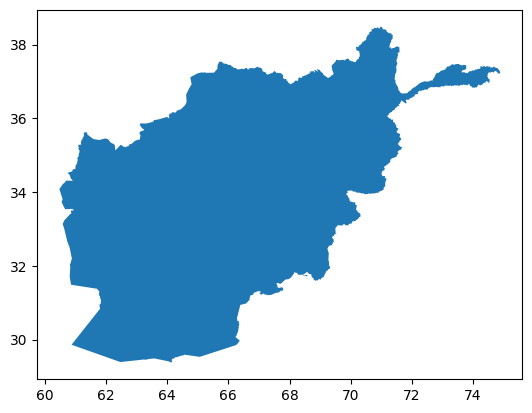

In [18]:
# Select adm if needed
gdf_in = gdf_in[gdf_in['ISO3'] == 'AFG']
gdf_in = gdf_in.to_crs('EPSG:4326')
gdf_in.plot()

In [19]:
aoi = geemap.geopandas_to_ee(gdf_in)
aoi_geomet = aoi.geometry()

# **Download**

### VIIRS Stray Light Corrected Nighttime Day/Night Band Composites Version 1

You can select VIIRS or VIIRS-LIKE.
For the VIIRS-LIKE dataset, see  https://essd.copernicus.org/articles/13/889/2021/  as well as https://gee-community-catalog.org/projects/npp_viirs_ntl/  for more details.

In [20]:
# Get all data

# VIIRS
viirs_all = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('avg_rad')

# VIIRS-LIKE
#viirs_all = ee.ImageCollection("projects/sat-io/open-datasets/npp-viirs-ntl").select('b1')


# Clip to the aoi
viirs_aoi = viirs_all.map(lambda x: x.clip(aoi_geomet))

Yearly downloader

In [ ]:
# Define year for the analysis

or y in range(2000, 2022):
#for y in [2022]:#Use this if you want to download a particular single year.

        m = 1
        print('Processing: {}-{}'.format(y, str(m).zfill(2)))

        viirs_tar = viirs_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('b1')
        viirs_out = viirs_tar.sum()


        # Export
        viirs_name = viirs_prefix + str(y)

        geemap.ee_export_image_to_drive(
            viirs_out,
            folder = 'viirs',
            description = viirs_name,
            region = aoi_geomet,
            scale = 463.83)

Processing: 2022-01


Monthly downloader

In [ ]:
# Define year for the analysis

for y in range(2014, 2024):
#for y in [2023]:#Use this if you want to download a particular single year.

    if y < 2023:
        for m in range(1, 13):
          print('Processing: {}-{}'.format(y, str(m).zfill(2)))

          viirs_tar = viirs_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('avg_rad')
          viirs_out = viirs_tar.sum()


          # Export
          viirs_name = viirs_prefix + str(y) + str(m).zfill(2)

          geemap.ee_export_image_to_drive(
              viirs_out,
              folder = 'viirs',
              description = viirs_name,
              region = aoi_geomet,
              scale = 463.83)


    else:
        for m in range(1, 13):
          print('Processing: {}-{}'.format(y, str(m).zfill(2)))

          viirs_tar = viirs_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('avg_rad')
          viirs_out = viirs_tar.sum()


          # Export
          viirs_name = viirs_prefix + str(y) + str(m).zfill(2)

          geemap.ee_export_image_to_drive(
              viirs_out,
              folder = 'viirs',
              description = viirs_name,
              region = aoi_geomet,
              scale = 463.83)

Processing: 2023-01
Processing: 2023-02
Processing: 2023-03


Processing: 2023-04
Processing: 2023-05
Processing: 2023-06
Processing: 2023-07
Processing: 2023-08
Processing: 2023-09
Processing: 2023-10
Processing: 2023-11
Processing: 2023-12


### VIIRS Nighttime Day/Night Annual Band Composites V2.1 (used for background noise reduction)

In [ ]:
# Get all data
viirs_ABCv21 = ee.ImageCollection("NOAA/VIIRS/DNB/ANNUAL_V21").select('average_masked')

# Clip to the aoi
viirs_ABCv21_aoi = viirs_ABCv21.map(lambda x: x.clip(aoi_geomet))

In [ ]:
# Define year for the analysis

for y in range(2014, 2022):
    m = 1
    print('Processing: {}'.format(y))

    viirs_tar = viirs_ABCv21_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('average_masked')
    viirs_out = viirs_ABCv21_aoi.sum()


    # Export
    viirs_name = viirs_prefix + 'maskV21_' + str(y)

    geemap.ee_export_image_to_drive(
        viirs_out,
        folder = 'viirs',
        description = viirs_name,
        region = aoi_geomet,
        scale = 463.83)

Processing: 2014
Processing: 2015
Processing: 2016
Processing: 2017
Processing: 2018
Processing: 2019
Processing: 2020
Processing: 2021


### VIIRS Nighttime Day/Night Annual Band Composites V2.2 (used for background noise reduction)

In [ ]:
# Get all data
viirs_ABCv22 = ee.ImageCollection("NOAA/VIIRS/DNB/ANNUAL_V22").select('average_masked')

# Clip to the aoi
viirs_ABCv22_aoi = viirs_ABCv22.map(lambda x: x.clip(aoi_geomet))

In [ ]:
# Define year for the analysis

for y in [2022]:
    m = 1
    print('Processing: {}'.format(y))

    viirs_tar = viirs_ABCv22_aoi.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).select('average_masked')
    viirs_out = viirs_ABCv22_aoi.sum()

    # Export
    viirs_name = viirs_prefix + 'maskV22_' + str(y)

    geemap.ee_export_image_to_drive(
        viirs_out,
        folder = 'viirs',
        description = viirs_name,
        region = aoi_geomet,
        scale = 463.83)

Processing: 2022
